In [1]:
import re
import spacy
import numpy as np
import codecs
import unidecode
import pandas as pd
from tqdm import tqdm
import nlpaug.augmenter.word as naw
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
nlp = spacy.load('en_core_web_sm')

#### Steps in tweet cleaning:
* Decoding: unicode_escape for extra “\” before unicode character, then unidecode
* Apostrophe handled: there are two characters people use for contraction. “’”(apostrophe) and “‘“(single quote). If these two symbols are both used for contraction, it will be difficult to detect and properly map the right expanded form. So any “’”(apostrophe) is changed to “‘“(single quote)
* Contraction check: check if there’s any contracted form, and replace it with its original form
* Parsing: done with Spacy
* Filtering punctuation, white space, numbers, URL using Spacy methods while keeping the text content of hashtag intact
* Removed @mention
* Special character removal
* Single syllable token removal
* Spell correction: it is a simple spell correction dealing with repeated characters such as “sooooo goooood”. If the same character is repeated more than two times, it shortens the repetition to two. For example “sooooo goooood” will be transformed as “soo good”. This is not a perfect solution since even after correction, in case of “soo”, it is not a correct spelling. But at least it will help to reduce feature space by making “sooo”, “soooo”, “sooooo” to the same word “soo”

In [2]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "cant": "cannot",
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            sc_removed = re.sub("[^a-zA-Z]", '', str(t))
            if len(sc_removed) > 1:
                final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [3]:
df = pd.read_csv('C:/Users/User/Desktop/FINAL-THESIS/en_dataset.csv')
print("Shape of dataframe: ", df.shape)
df.head(15)

Shape of dataframe:  (5647, 7)


,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,call sis im boy girl still faggot shut,offensive,indirect,confusion_disgust,origin,gay
1,2,@user @user legit nilas retarded idk,offensive_disrespectful,indirect,anger_confusion,disability,special_needs
2,3,said retard @url,fearful_abusive_offensive_hateful,indirect,confusion_disgust,disability,special_needs
3,4,america another 8 years obama's ideology via h...,fearful_abusive_hateful_disrespectful_normal,indirect,anger_fear_shock_sadness_disgust,origin,other
4,5,@user don... fucking made cry twat.,offensive,indirect,shock_disgust,gender,women
5,6,one wants 2 negro swan,offensive,indirect,anger_sadness,origin,left_wing_people
6,7,@user @user @user hahaha. one trump's shithole...,offensive,indirect,confusion_sadness_indifference_disgust,origin,other
7,8,u juul ur faggot,offensive,indirect,confusion_fear_indifference_sadness_disgust,sexual_orientation,other
8,9,@user @user even called country shithole peopl...,offensive,indirect,anger_fear_indifference_sadness_disgust,origin,special_needs
9,10,canadians never met seen associated person cur...,offensive,indirect,sadness_indifference,disability,special_needs


In [4]:
# Separating out each of the labels to different words
def split_sentiment_outputs(output_label, sentiment_col="sentiment"):
    df[output_label] = df[sentiment_col].str.split('_')
    

# Converting the dataframe to have one column for each of the labels.
def transform_data_for_multilabel(output_label):
    row = df[output_label]
    for index, row in row.items():
        z = 0
        while z < len(row):
            if row[z] == output_label:
                df.at[index, output_label] = 1
                break
            else:
                df.at[index, output_label] = 0
            z = z + 1
            
output_labels = ["abusive", "hateful", "offensive", "disrespectful", "fearful", "normal"]
n_labels = len(output_labels)

In [5]:
for i in range(n_labels):
    split_sentiment_outputs(output_labels[i])
    
for i in range(n_labels):
    transform_data_for_multilabel(output_labels[i])

# Removing unnecessary columns from dataframe
df = df.drop(['directness', 'annotator_sentiment', 'target', 'group','HITId'], axis=1)

# Removing the 'sentiment' column as it is not needed anymore after all necessary information has been extracted
df = df.drop(['sentiment'], axis=1)

# Removing all duplicate rows
df = df.drop_duplicates()

# Applying the tweet cleaning function to each of the tweets
df['tweet_cleaned'] = df['tweet'].apply(lambda x: spacy_cleaner(x))

# Generating the number of words of each tweet in a column
df['tweet_length'] = df['tweet_cleaned'].apply(lambda x: len(x.split(' ')))

# Discard Empty Tweets if There Any.
empty_tweet_filter = df['tweet_cleaned'] != ""
df = df[empty_tweet_filter]
df = df.dropna()

print("Shape of dataframe: ", df.shape)
df.head(15)

Shape of dataframe:  (5616, 9)


,tweet,abusive,hateful,offensive,disrespectful,fearful,normal,tweet_cleaned,tweet_length
0,call sis im boy girl still faggot shut,0,0,1,0,0,0,call sis boy girl still faggot shut,7
1,@user @user legit nilas retarded idk,0,0,1,1,0,0,legit nilas retarded idk,4
2,said retard @url,1,1,1,0,1,0,said retard,2
3,america another 8 years obama's ideology via h...,1,1,0,1,1,1,america another years obama ideology via hilla...,13
4,@user don... fucking made cry twat.,0,0,1,0,0,0,don fucking made cry twat,5
5,one wants 2 negro swan,0,0,1,0,0,0,wants negro swan,3
6,@user @user @user hahaha. one trump's shithole...,0,0,1,0,0,0,hahaha trump shithole countries,4
7,u juul ur faggot,0,0,1,0,0,0,juul ur faggot,3
8,@user @user even called country shithole peopl...,0,0,1,0,0,0,even called country shithole people shithole p...,8
9,canadians never met seen associated person cur...,0,0,1,0,0,0,canadians never met seen associated person cur...,10


Value Counts of Categories:

abusive: 670
hateful: 1277
offensive: 3992
disrespectful: 781
fearful: 562
normal: 1354
     abusive hateful offensive disrespectful fearful normal
0          0       0         1             0       0      0
1          0       0         1             1       0      0
2          1       1         1             0       1      0
3          1       1         0             1       1      1
4          0       0         1             0       0      0
...      ...     ...       ...           ...     ...    ...
5642       0       1         0             0       0      0
5643       0       0         1             0       1      0
5644       0       1         0             0       0      0
5645       0       0         0             0       0      1
5646       0       0         1             0       0      0

[5616 rows x 6 columns]


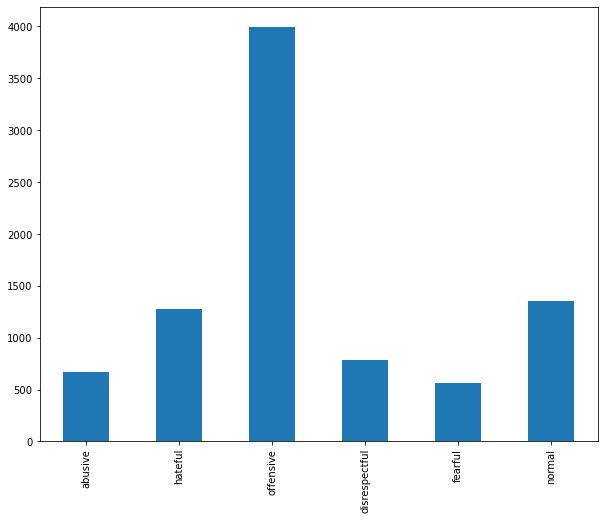

In [6]:
print("Value Counts of Categories:\n")
for category in df.columns[1:7]:
    print(f"{category}: {df[category].sum()}")
    

    #Plot the Distribution of Target Labels in the Dataset
df2 = df[df.columns[1:7]]
print(df2)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
df2.sum(axis=0).plot.bar()
plt.show()

In [7]:
#Data splitting - TRAIN-TEST-DEV-> 8:1:1
def split_df(df):
    if len(df) % 2 != 0:  # Handling `df` with `odd` number of rows
        df = df.iloc[:-1, :]
    df1, df2 =  np.array_split(df, 2)
    return df1, df2

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2021)
df_test, df_val = split_df(df_test)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

print("\n Value Counts of Training set Categories before augmentation and after split:\n")
for category in df_train.columns[1:7]:
    print(f"{category}: {df_train[category].sum()}")

print("\n Value Counts of Val set Categories before augmentation and after split:\n")
for category in df_val.columns[1:7]:
    print(f"{category}: {df_val[category].sum()}")

print("\n Value Counts of Test set Categories before augmentation and after split:\n")
for category in df_test.columns[1:7]:
    print(f"{category}: {df_test[category].sum()}")

(4492, 9)
(562, 9)
(562, 9)

 Value Counts of Training set Categories before augmentation and after split:

abusive: 538
hateful: 1031
offensive: 3187
disrespectful: 638
fearful: 465
normal: 1096

 Value Counts of Val set Categories before augmentation and after split:

abusive: 72
hateful: 124
offensive: 398
disrespectful: 71
fearful: 50
normal: 130

 Value Counts of Test set Categories before augmentation and after split:

abusive: 60
hateful: 122
offensive: 407
disrespectful: 72
fearful: 47
normal: 128


In [9]:
df_train = df_train.drop(columns=['tweet_length'])
df_test = df_test.drop(columns=['tweet_length'])
df_val = df_val.drop(columns=['tweet_length'])

df_train.to_csv('C:/Users/User/Desktop/FINAL-THESIS/training_set_en_dataset_without_aug.csv', index=False)
df_test.to_csv('C:/Users/User/Desktop/FINAL-THESIS/test_set_en_dataset_without_aug.csv', index=False)
df_val.to_csv('C:/Users/User/Desktop/FINAL-THESIS/val_set_en_dataset_without_aug.csv', index=False)